In [1]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import sys
import shapely
import Helper_Methods as hm
from scipy.spatial import cKDTree
import numpy as np
import rasterstats
import rasterio
from rasterio.plot import show
import georaster
from PIL import Image
from PIL.TiffTags import TAGS
from osgeo import gdal

In [2]:
%%time
route_paths = "./Data/Routes/Comprehensive_Routes/KCM_Routes.shp"
routes = gpd.read_file(route_paths).to_crs(epsg = 4326)

CPU times: user 443 ms, sys: 5.06 ms, total: 448 ms
Wall time: 446 ms


In [3]:
'''
elevations_path = "./Data/Lidar/LIDAR.shp"
elevations_raw = gpd.read_file(elevations_path)
elevations = elevations_raw.copy()
'''

'\nelevations_path = "./Data/Lidar/LIDAR.shp"\nelevations_raw = gpd.read_file(elevations_path)\nelevations = elevations_raw.copy()\n'

In [4]:
route = 22

In [5]:
import georaster

In [6]:
def organize_linestring(string):
    cat_string = string[12:-1]
    coord_list = cat_string.split(', ')
    coord_ser = pd.Series(coord_list).apply(lambda x: shapely.Point(x.split(' ')[0], x.split(' ')[1]))
    coord_ser = gpd.GeoSeries(coord_ser)
    return coord_ser

In [7]:
def get_rasterfiles(dir_path):
    '''
    get all non-reprojected rasterfiles in a given directory. Returns a pandas series of paths.
    '''
    rasterfiles_raw = pd.Series(os.listdir(dir_path))
    rasterfiles_raw = rasterfiles_raw[rasterfiles_raw.apply(lambda x: ('tif' in (x.split("."))[-1]))].reset_index(drop='true')
    rasterfiles = rasterfiles_raw[rasterfiles_raw.apply(lambda x: ('reproject' not in x))].reset_index(drop='true')
    rasterfiles = rasterfiles.apply(lambda x: "{}{}".format(dir_path, x))
    return rasterfiles

In [8]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os.path

def reproject_rasterfiles(filepath_sequence, target_crs='EPSG:4326'):
    '''
    Take the filepaths for raster files in a pandas series, and reproject them
    to a target CRS, defaulting to EPSG:4326
    '''
    for path in list(filepath_sequence):
        print(path)
        #CHECK IF THE REPROJECTED FILE EXISTS
        if (os.path.isfile(path + '_reproject.tif')==False):
            with rasterio.open(path) as src:
                transform, width, height = calculate_default_transform(
                    src.crs, target_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })

                with rasterio.open(path+'_reproject.tif', 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=target_crs,
                            resampling=Resampling.nearest)
                    
    return filepath_sequence.astype(str) + "_reproject.tif"

In [9]:
def query_elevation_benchmarks(bench_data, model_path, model_prefix = ""):
    all_benchmarks = {}
    for path in list(model_path):
        with rasterio.open(path) as img:
            bench_data['raster_elev'] = list(rasterio.sample.sample_gen(img, list(bench_data['ll_tuple']), masked=True))
            filtered_benchmarks = bench_data[bench_data['raster_elev'].apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]

            for row_2, col_2 in filtered_benchmarks.iterrows():
                data_dict = {'True_elevation':col_2['ELEVATION'], '{}_Model_elevation'.format(model_prefix):col_2['raster_elev'][0]}
                all_benchmarks[row_2] = data_dict
    return all_benchmarks

In [10]:
dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])

    

dsm_raster_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/"
dtm_raster_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dtm/"
DSM_rasters_raw = get_rasterfiles(dsm_raster_path)
DTM_rasters_raw = get_rasterfiles(dtm_raster_path)

reprojected_DSMs = reproject_rasterfiles(DSM_rasters_raw)
reprojected_DTMs = reproject_rasterfiles(DTM_rasters_raw)

./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_100.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_101.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_102.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_103.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_104.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_105.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_106.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2021_dsm_86.tif
./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/king_county_west_2

In [11]:
benchmark_paths = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_Survey_Benchmarks/KC_SURV.shp"
benchmarks = gpd.read_file(benchmark_paths).to_crs(epsg = 4326)

benchmarks['ll_tuple'] = benchmarks['geometry'].apply(lambda x: (x.x, x.y))

dsm_benchmark_comparison = pd.DataFrame(query_elevation_benchmarks(benchmarks, reprojected_DSMs, "DSM")).T.sort_index()
dtm_benchmark_comparison = pd.DataFrame(query_elevation_benchmarks(benchmarks, reprojected_DTMs, "DTM")).T.sort_index()
# convert dsm and dtm elevations from feet to meters:
dsm_benchmark_comparison['DSM_Model_elevation'] = dsm_benchmark_comparison['DSM_Model_elevation']*.3048
dtm_benchmark_comparison['DTM_Model_elevation'] = dtm_benchmark_comparison['DTM_Model_elevation']*.3048
benchmark_comparison = pd.merge(dsm_benchmark_comparison, dtm_benchmark_comparison, left_index=True, right_index=True)

In [12]:
import scipy.optimize
def fit_linear_data(xdata, ydata):
    def linfunc(x, m, b):
        y=m*x+b
        return y
    parameters, covariance = scipy.optimize.curve_fit(linfunc, xdata, ydata)
    pred_y = linfunc(xdata, parameters[0], parameters[1])
    squared_res = ((pred_y-ydata)**2).sum()
    total_squares = ((ydata-ydata.mean())**2).sum()
    MSE = ((pred_y-ydata)**2).mean()
    r_squared = 1-(squared_res/total_squares)
    return parameters, MSE, r_squared, pred_y

y=0.9966640993486034x+1.465358749801565
mean_squared_error: 133.07561165374258
r_squared: 0.952486475920009


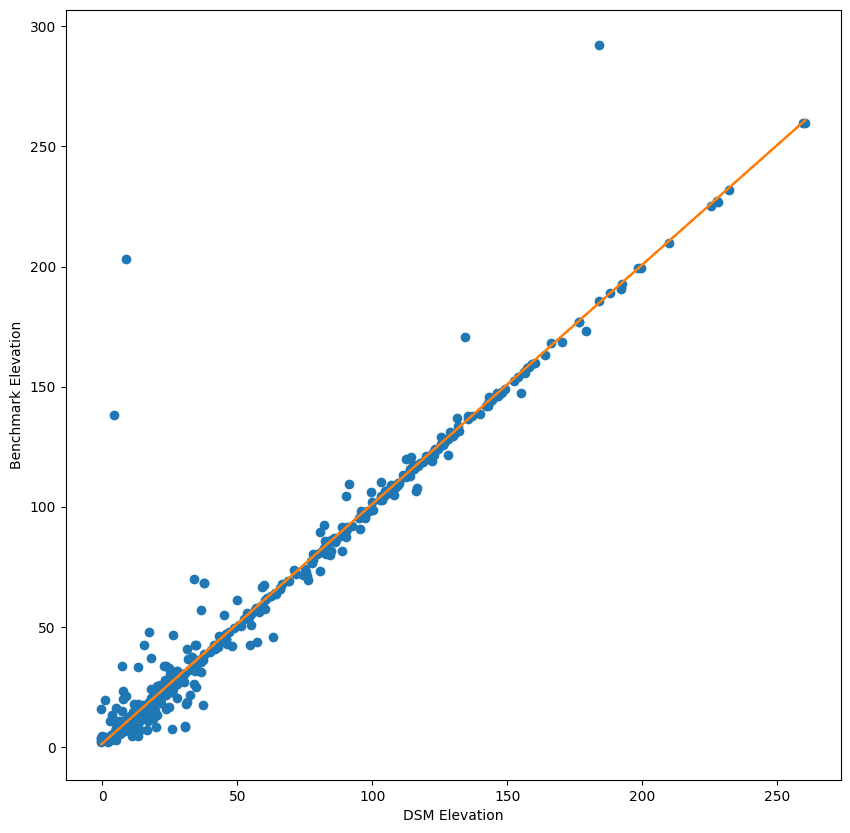

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
dtm_elev = dtm_benchmark_comparison['DTM_Model_elevation'].apply(float)
true_dtm = dtm_benchmark_comparison['True_elevation'].apply(float)
ax.scatter(dtm_elev, true_dtm)
ax.set_xlabel("DSM Elevation")
ax.set_ylabel("Benchmark Elevation")
params, mse, r2, pred_elev = fit_linear_data(dtm_elev, true_dtm)
ax.plot(dtm_elev, pred_elev, c="tab:orange")
print("y={}x+{}".format(params[0], params[1]))
print("mean_squared_error: {}".format(mse))
print("r_squared: {}".format(r2))

y=0.9719174268681845x+-0.7666021447101472
mean_squared_error: 149.03833070441777
r_squared: 0.948345747168738


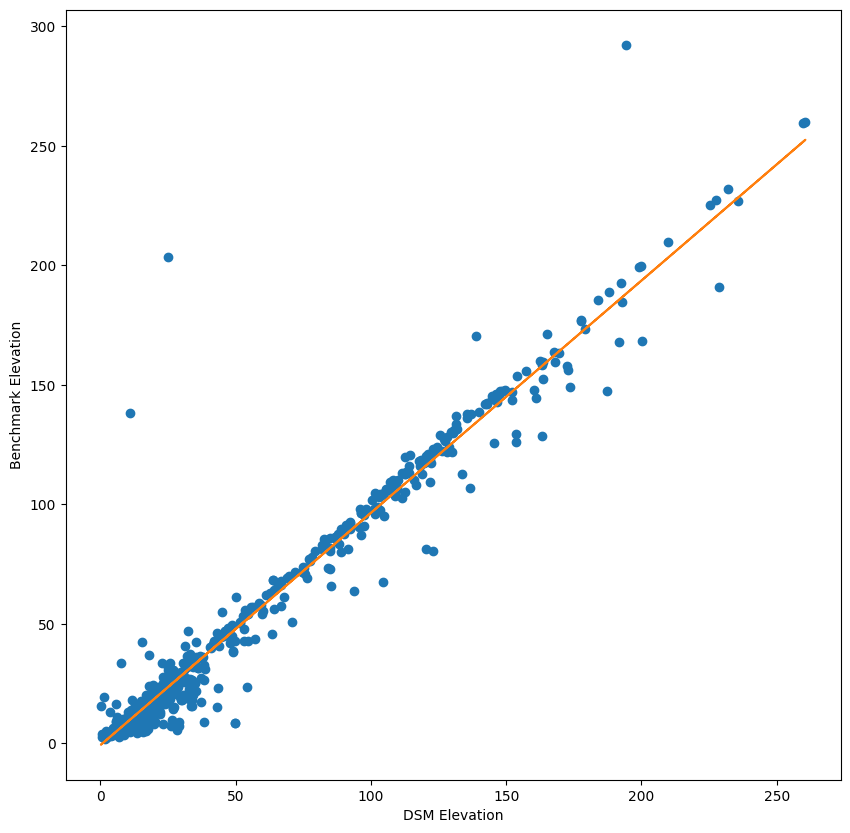

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
dsm_elev = dsm_benchmark_comparison['DSM_Model_elevation'].apply(float)
true_dsm = dsm_benchmark_comparison['True_elevation'].apply(float)
ax.scatter(dsm_elev, true_dsm)
ax.set_xlabel("DSM Elevation")
ax.set_ylabel("Benchmark Elevation")
params, mse, r2, pred_elev = fit_linear_data(dsm_elev, true_dsm)
ax.plot(dsm_elev, pred_elev, c="tab:orange")
print("y={}x+{}".format(params[0], params[1]))
print("mean_squared_error: {}".format(mse))
print("r_squared: {}".format(r2))

Text(0, 0.5, 'DSM Model %error')

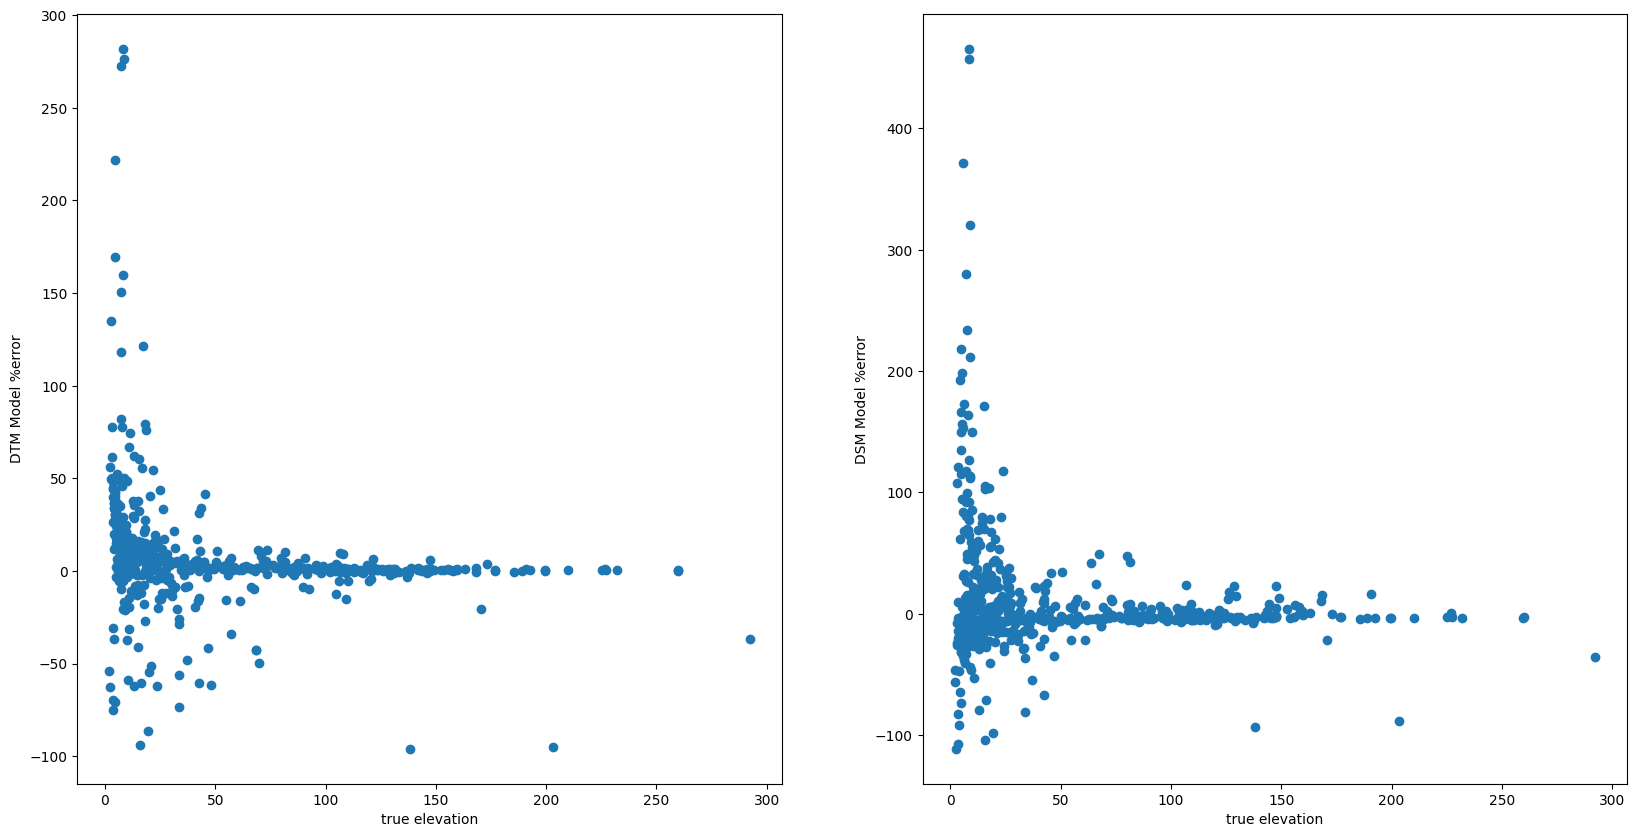

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
merged_dtm = benchmark_comparison["DTM_Model_elevation"].apply(float)
merged_dsm = benchmark_comparison["DSM_Model_elevation"].apply(float)
merged_true = benchmark_comparison['True_elevation_y'].apply(float)

merged_dtm_prediction = 0.9966640993486034*merged_dtm+1.465358749801565
merged_dsm_prediction = 0.9719174268681845*merged_dsm-0.7666021447101472

dtm_error = (merged_dtm_prediction - merged_true)/merged_true * 100
dsm_error = (merged_dsm_prediction - merged_true)/merged_true * 100
ax[0].scatter(merged_true, (dtm_error))
ax[1].scatter(merged_true, (dsm_error))
ax[0].set_xlabel("true elevation")
ax[0].set_ylabel("DTM Model %error")
ax[1].set_xlabel("true elevation")
ax[1].set_ylabel("DSM Model %error")

DSM:
	 mean: 2.1621974833312514, med: 0.357866549682619, std: 12.358910814635452
DTM:
	 mean: -1.3107732048833918, med: -0.03914042663573625, std: 11.54630296604193


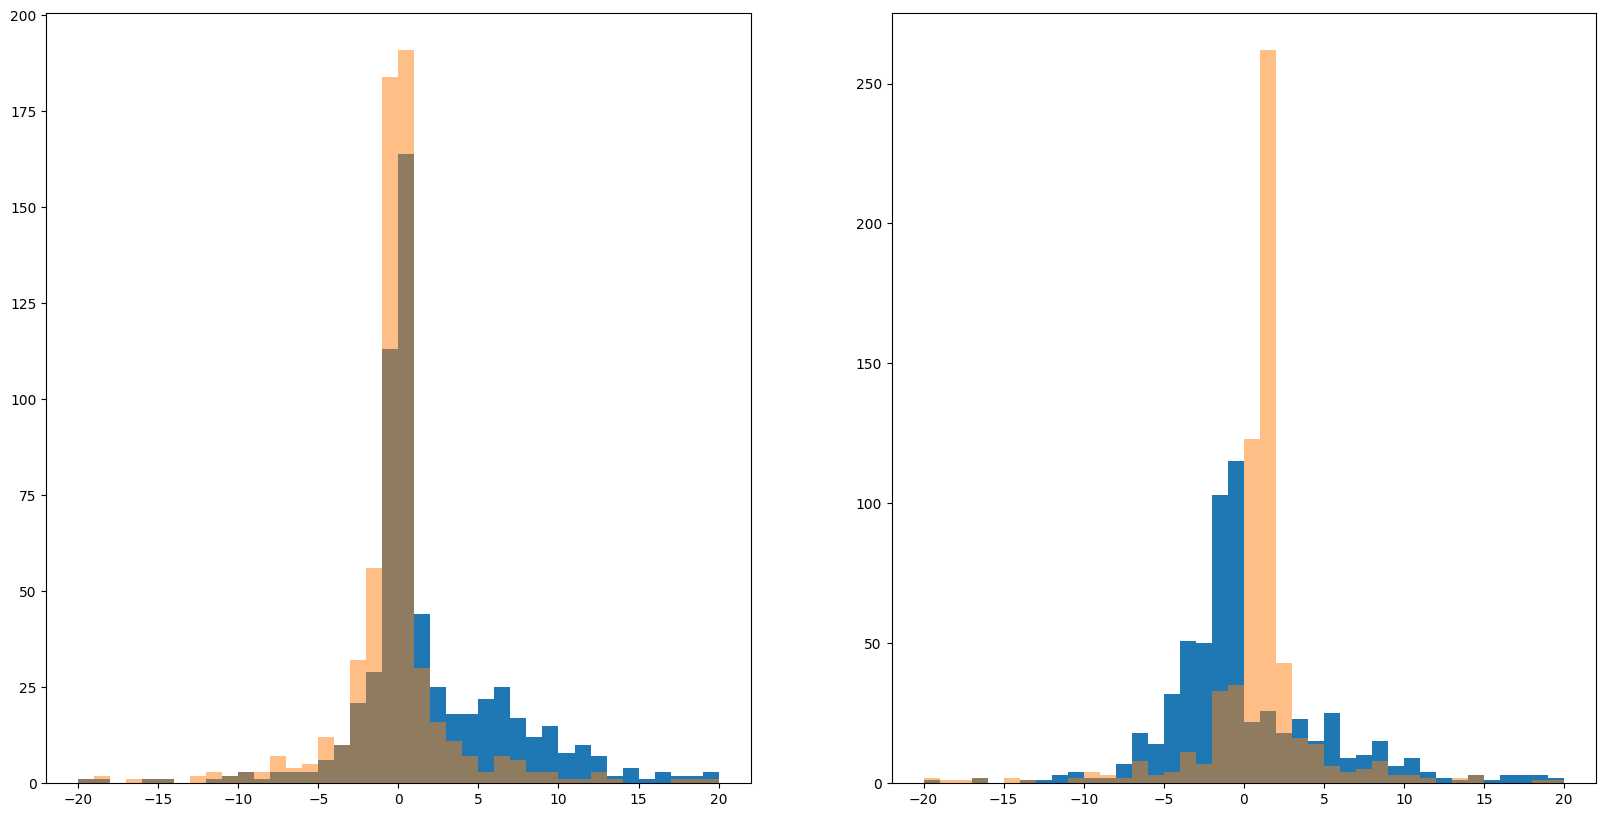

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
bins = [-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

dsm_diff = merged_dsm-merged_true
dsm_mean_offset = dsm_diff.mean()
dsm_std_offset = dsm_diff.std()
dsm_med_offset = dsm_diff.median()

dtm_diff = merged_dtm-merged_true
dtm_mean_offset = dtm_diff.mean()
dtm_std_offset = dtm_diff.std()
dtm_med_offset = dtm_diff.median()

ax[0].hist(dsm_diff, bins=bins, alpha=1)
ax[0].hist(dtm_diff, bins=bins, alpha=.5)
ax[1].hist(merged_dsm_prediction-merged_true, bins=bins, alpha=1)
ax[1].hist(merged_dtm_prediction-merged_true, bins=bins, alpha=.5)

# orange: digital terrain model (last ping back)
# blue: digital surface model (first ping back)

# positive means that the prediciton is higher than the true value
# negative means the prediciton is lower than the true value

#Both DTM and DSM are typically within +/-1 meter of the true elevation
#linearized model projects that the DTM overapproximates by around 3 meters
#linearized model projects the DSM is typically under the benchmarked value, these are both counter-intuitive.
# When DTM suddently drops off, use DSM. When DSM is suddenly large, use DTM. 
print("DSM:")
print("\t mean: {}, med: {}, std: {}".format(dsm_mean_offset, dsm_med_offset, dsm_std_offset))
print("DTM:")
print("\t mean: {}, med: {}, std: {}".format(dtm_mean_offset, dtm_med_offset, dtm_std_offset))

In [17]:
import scipy.optimize
def fit_double_data(x1data, x2data, ydata):
    def bivarfunc(x, m1, m2, b):
        y=m1*x[0] + m2+x[1] +b
        return y
    parameters, covariance = scipy.optimize.curve_fit(bivarfunc, [x1data, x2data], ydata)
    print(parameters)
    pred_y = bivarfunc([x1data, x2data], parameters[0], parameters[1], parameters[2])
    squared_res = ((pred_y-ydata)**2).sum()
    total_squares = ((ydata-ydata.mean())**2).sum()
    MSE = ((pred_y-ydata)**2).mean()
    r_squared = 1-(squared_res/total_squares)
    return parameters, MSE, r_squared, pred_y

[-1.77450221e-02  4.91613839e+03 -4.91747828e+03]
y=-0.017745022115339903*x1+4916.138388281638*x2+-4917.478281716881
mean_squared_error: 151.65456837060643
r_squared: 0.9458530162170794


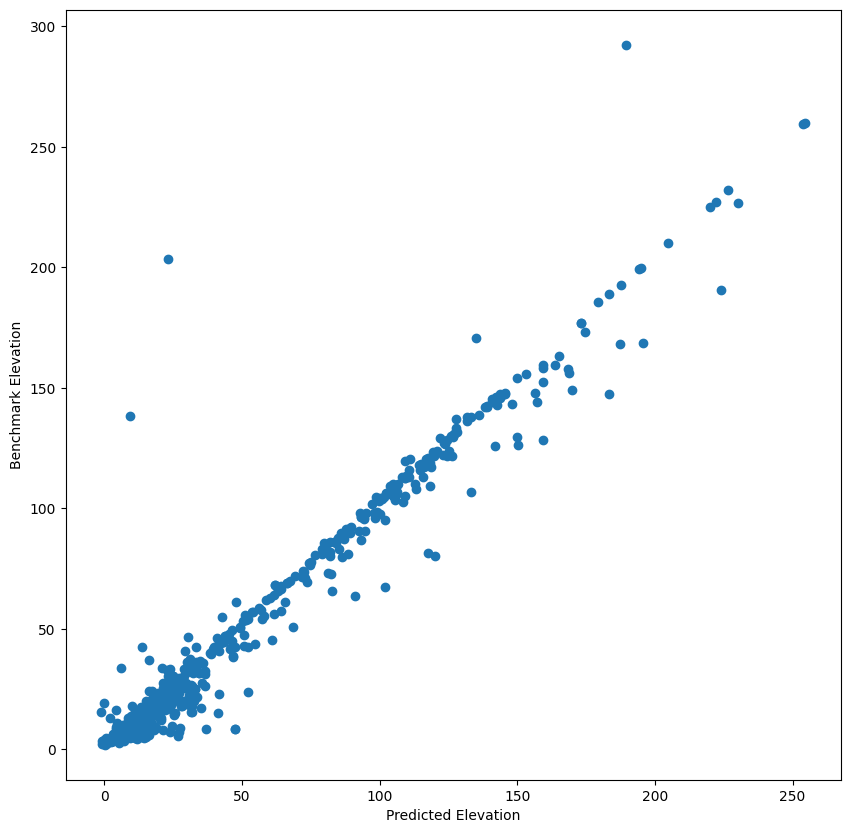

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.set_xlabel("Predicted Elevation")
ax.set_ylabel("Benchmark Elevation")
params, mse, r2, pred_elev = fit_double_data(merged_dtm, merged_dsm, merged_true)
ax.scatter(pred_elev, true_dtm)
print("y={}*x1+{}*x2+{}".format(params[0], params[1], params[2]))
print("mean_squared_error: {}".format(mse))
print("r_squared: {}".format(r2))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0., 392.,  29.,
         23.,  13.,  19.,  23.,  16.,  14.,  18.,  12.,  11.,   7.,  10.,
          2.,   2.,   2.,   4.,   5.,   2.,   3.]),
 array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]),
 <BarContainer object of 40 artists>)

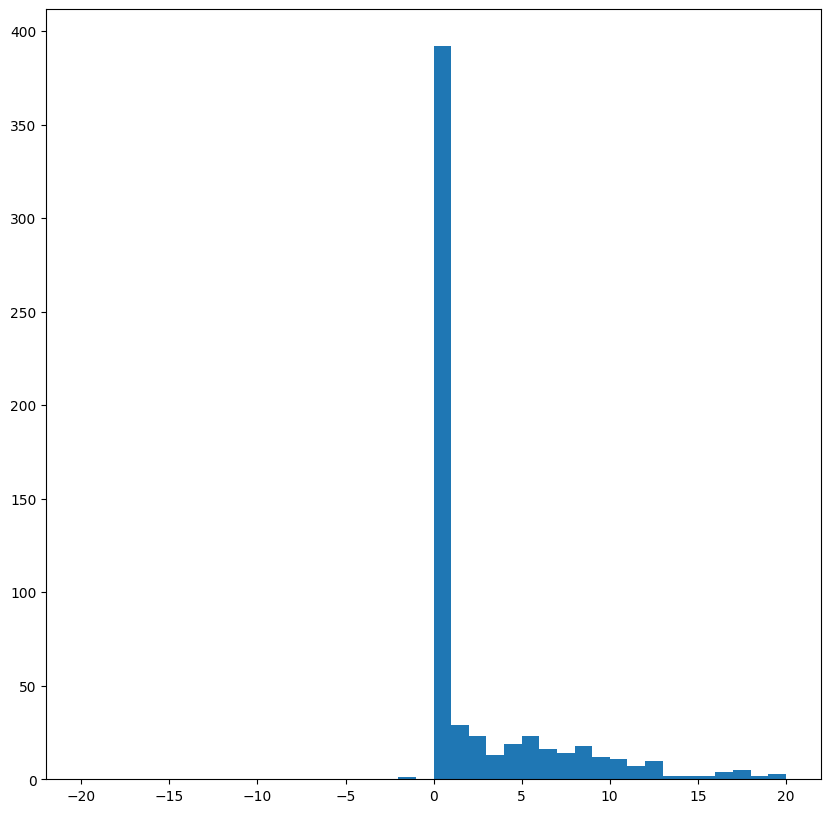

In [19]:
type_diff =(merged_dsm - merged_dtm)
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(type_diff, bins=bins)

In [37]:
import RouteMap as rm
route_data_dir = "./Data/Routes/Individual_Routes/"
routefiles_raw = pd.Series(os.listdir(route_data_dir))
routefiles = routefiles_raw[routefiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
routefiles = routefiles.apply(lambda x: "{}{}".format(route_data_dir, x))
route_shape = gpd.read_file(routefiles[0])
# Get the route geometry 
route_sampled = route_shape[::].reset_index(drop=True)
route_geometry = route_sampled['geometry']
route_elevation = route_sampled['Z']
route_map = rm.RouteMap(route_geometry, route_elevation)
old_elev = route_map.get_elevation()
old_smooth_elev = route_map.smooth_elevation()
# why cant i just append anymore, pandas? this is dumb.
old_dist = (pd.concat([route_map.crow_dist(), pd.Series([np.nan])])).reset_index(drop=True).cumsum()
old_raw_grades = route_map.get_grade()
old_smooth_grades = (route_map.set_elevation(old_smooth_elev)).get_grade()


In [38]:
old_dist

0             NaN
1        0.002498
2        0.004995
3        0.007493
4        0.009990
          ...    
9714    24.116560
9715    24.119036
9716    24.121511
9717    24.123986
9718          NaN
Length: 9719, dtype: float64

(array([0.02552228, 0.02464752, 0.04157662, 0.07188433, 0.07965421,
        0.09118041, 0.07157559, 0.04234846, 0.02428733, 0.02732325]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

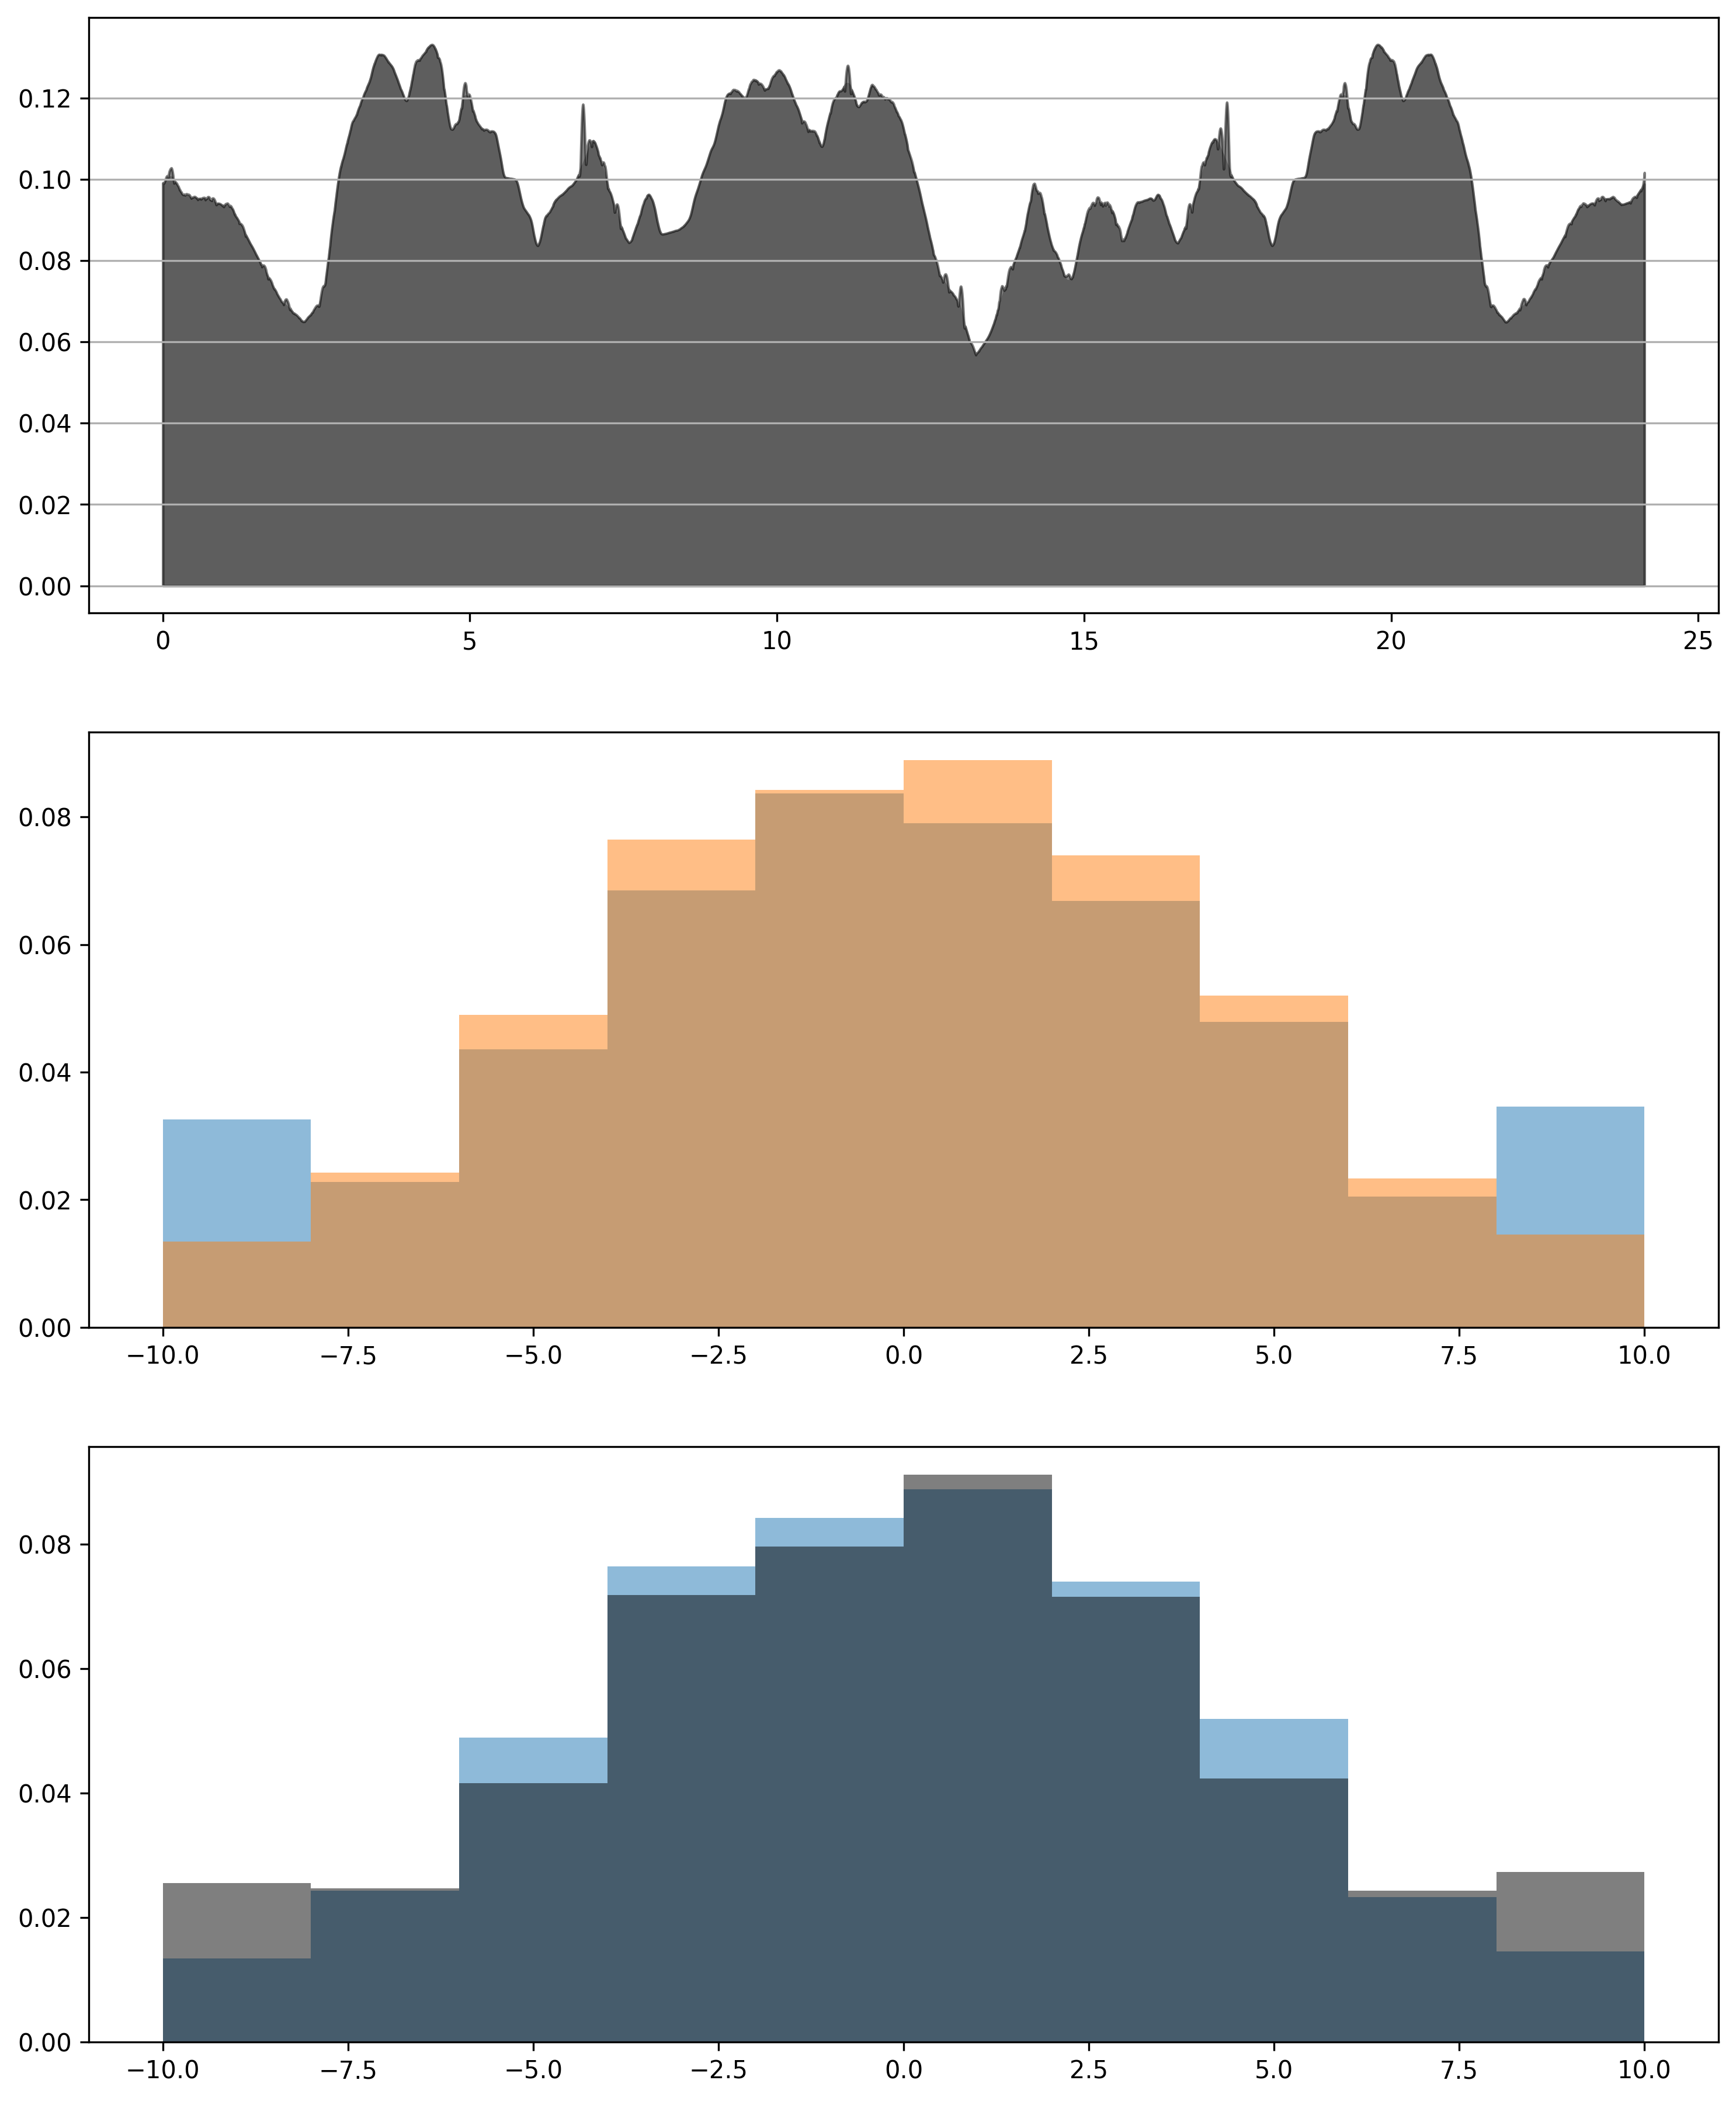

In [48]:
import RouteMap as rm
route_ll = (route_geometry.apply(lambda x: (x.x, x.y))).reset_index(drop=True)
data_dict = {}

for path in list(reprojected_DSMs):
        with rasterio.open(path) as img:
            route_DSM = pd.Series(list(rasterio.sample.sample_gen(img, list(route_ll), masked=True)))
            filtered_benchmarks = route_DSM[route_DSM.apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
            #print(filtered_benchmarks)
            for index in filtered_benchmarks.index:
                data_dict[index] = {'ll':route_ll[index], 'elev':filtered_benchmarks[index]}
rt22elev_DSM = pd.DataFrame(data_dict).T.sort_index()
rt22elev_DSM['elev'] = rt22elev_DSM['elev'].apply(float)
rt22elev_DSM['ll'] = rt22elev_DSM['ll'].apply(shapely.Point)

route_map = rm.RouteMap(rt22elev_DSM['ll'], rt22elev_DSM['elev'])
raw_DSM_elev = route_map.get_elevation()
smooth_DSM_elev = route_map.smooth_elevation()
DSM_dist = (pd.concat([route_map.crow_dist(), pd.Series([np.nan])])).reset_index(drop=True).cumsum()
raw_grades = route_map.get_grade()
smooth_grades = (route_map.set_elevation(smooth_DSM_elev)).get_grade()



fig, ax = plt.subplots(3,1, figsize = (12, 15), dpi=300)

#ax[0].plot(DTM_dist, raw_DTM_elev)
ax[0].fill_between(DTM_dist, smooth_DTM_elev, color = '#BDBDBD')
ax[0].fill_between(old_dist, old_smooth_elev, color = '#000000', alpha=.5)
ax[0].grid(axis='y')
ax[1].hist(raw_grades, alpha=.5, density=True)
ax[1].hist(smooth_grades, alpha=.5, density=True)
ax[2].hist(smooth_grades, alpha=.5, density=True)
ax[2].hist(old_smooth_grades, color="#000000", alpha=.5, density=True)

(array([0.02552228, 0.02464752, 0.04157662, 0.07188433, 0.07965421,
        0.09118041, 0.07157559, 0.04234846, 0.02428733, 0.02732325]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

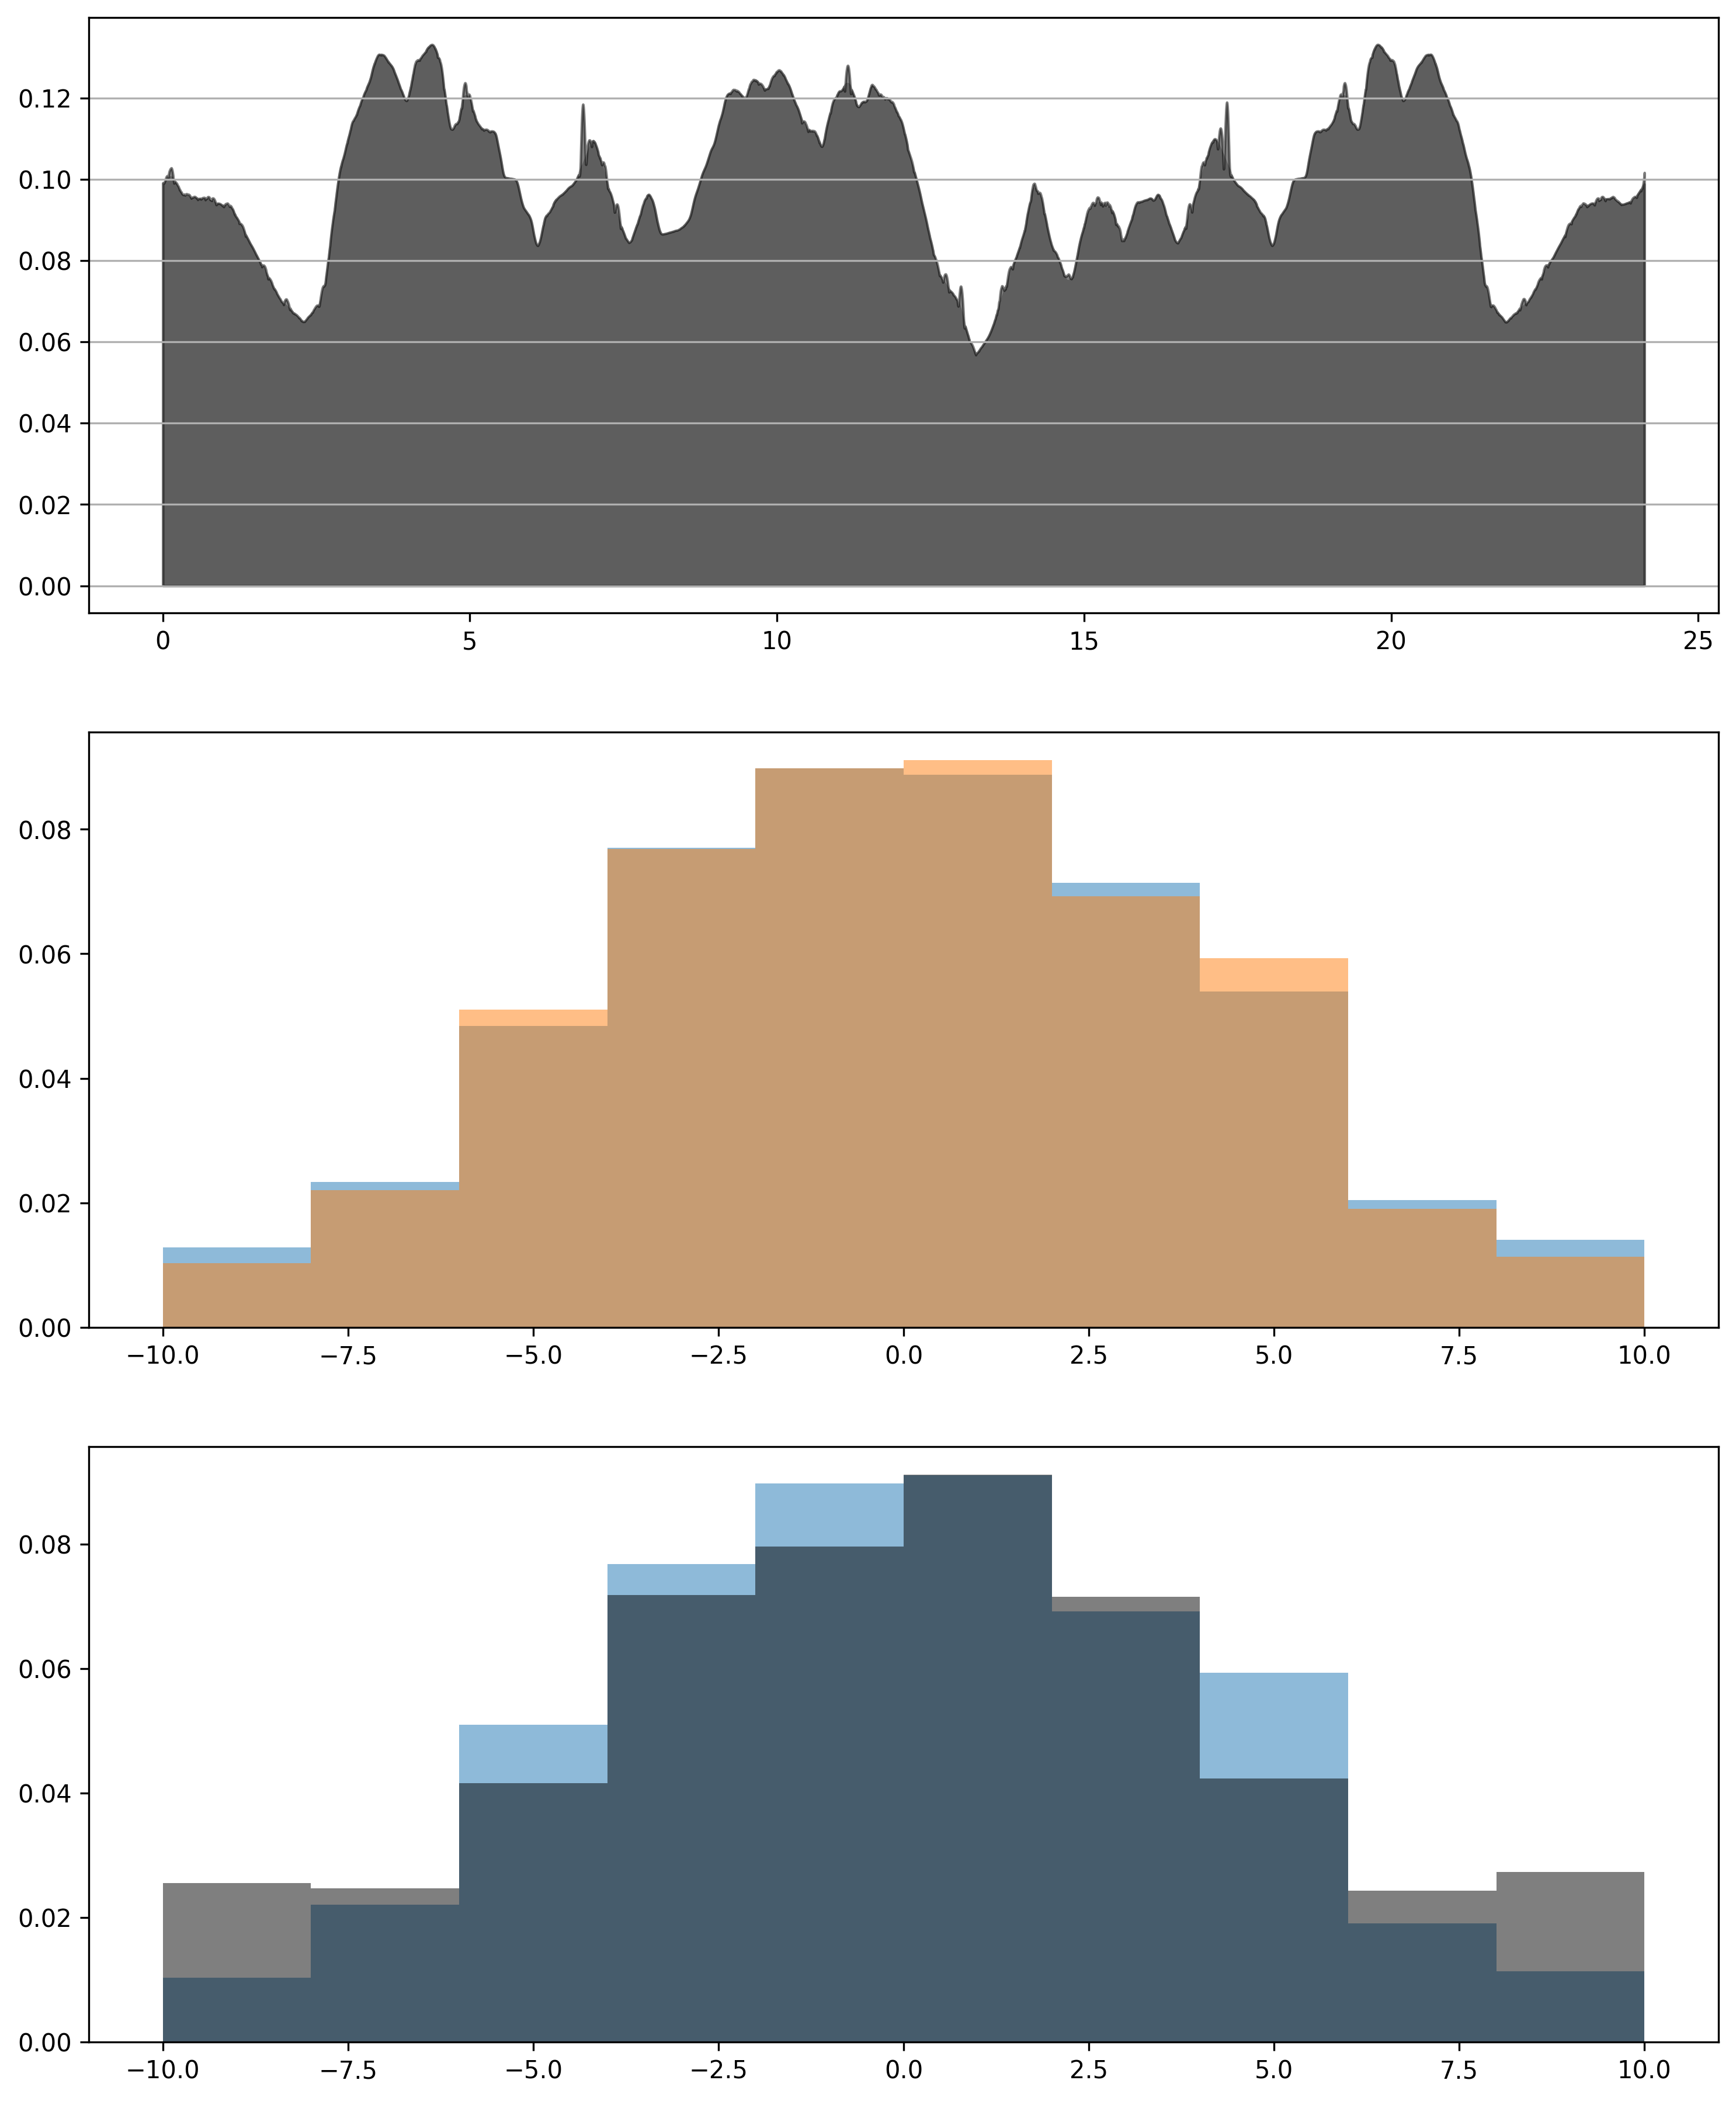

In [47]:
import RouteMap as rm
route_ll = (route_geometry.apply(lambda x: (x.x, x.y))).reset_index(drop=True)
data_dict = {}

for path in list(reprojected_DTMs):
        with rasterio.open(path) as img:
            route_DTM = pd.Series(list(rasterio.sample.sample_gen(img, list(route_ll), masked=True)))
            filtered_benchmarks = route_DTM[route_DTM.apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
            #print(filtered_benchmarks)
            for index in filtered_benchmarks.index:
                data_dict[index] = {'ll':route_ll[index], 'elev':filtered_benchmarks[index]}
rt22elev_DTM = pd.DataFrame(data_dict).T.sort_index()
rt22elev_DTM['elev'] = rt22elev_DTM['elev'].apply(float)
rt22elev_DTM['ll'] = rt22elev_DTM['ll'].apply(shapely.Point)

route_map = rm.RouteMap(rt22elev_DTM['ll'], rt22elev_DTM['elev'])
raw_DTM_elev = route_map.get_elevation()
smooth_DTM_elev = route_map.smooth_elevation()
DTM_dist = (pd.concat([route_map.crow_dist(), pd.Series([np.nan])])).reset_index(drop=True).cumsum()
raw_grades = route_map.get_grade()
smooth_grades = (route_map.set_elevation(smooth_DTM_elev)).get_grade()



fig, ax = plt.subplots(3,1, figsize = (12, 15), dpi=300)

#ax[0].plot(DTM_dist, raw_DTM_elev)
ax[0].fill_between(DTM_dist, smooth_DTM_elev, color = '#BDBDBD')
ax[0].fill_between(old_dist, old_smooth_elev, color = '#000000', alpha=.5)
ax[0].grid(axis='y')
ax[1].hist(raw_grades, alpha=.5, density=True)
ax[1].hist(smooth_grades, alpha=.5, density=True)
ax[2].hist(smooth_grades, alpha=.5, density=True)
ax[2].hist(old_smooth_grades, color="#000000", alpha=.5, density=True)

In [70]:
DTM_dist

,point_distances[km],cumulative_distance[km]
0,NaN,NaN
1,[0.14001822],[0.14001822]
2,[0.07942352],[0.21944174]
3,[0.06223582],[0.28167757]
4,[0.28078154],[0.5624591]
...,...,...
390,[0.028830737],[25.79502]
391,[0.012294445],[25.807314]
392,[0.17385387],[25.981167]
393,[0.0087138],[25.989882]


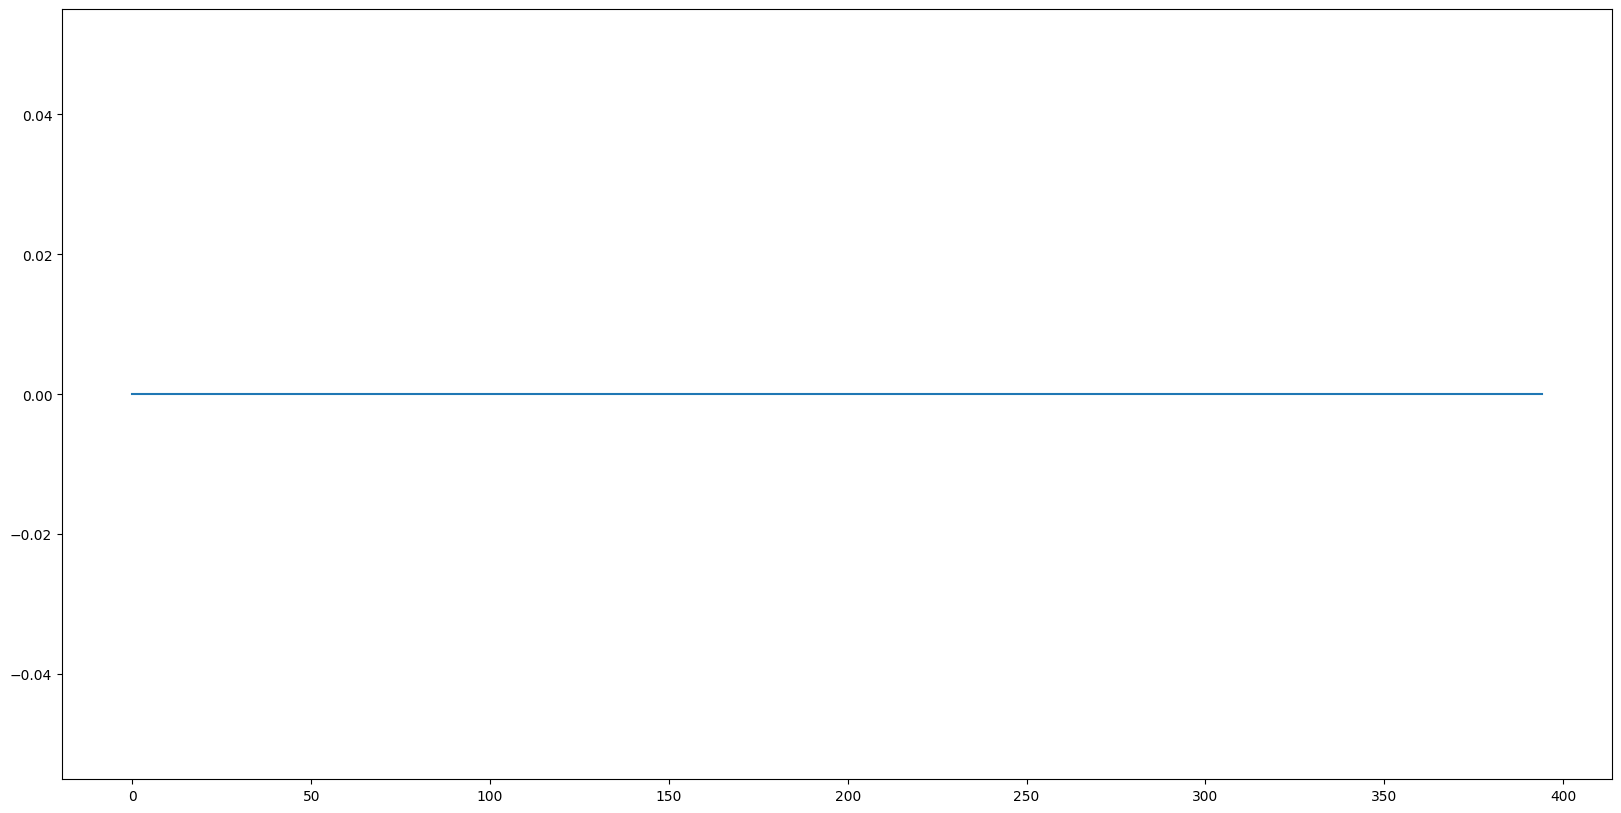

In [ ]:
benchmark_paths = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_Survey_Benchmarks/KC_SURV.shp"
benchmarks = gpd.read_file(benchmark_paths).to_crs(epsg = 4326)

benchmarks['ll_tuple'] = benchmarks['geometry'].apply(lambda x: (x.x, x.y))

def query_elevation_benchmarks(bench_data, model_path):
    all_benchmarks = {}
    for path in list(model_path):
        with rasterio.open(path) as img:
            bench_data['raster_elev'] = list(rasterio.sample.sample_gen(img, list(bench_data['ll_tuple']), masked=True))
            filtered_benchmarks = bench_data[bench_data['raster_elev'].apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]

            for row_2, col_2 in filtered_benchmarks.iterrows():
                data_dict = {'True_elevation':col_2['ELEVATION'], 'Model_elevation':col_2['raster_elev']}
                all_benchmarks[row_2] = data_dict
    return all_ben

In [116]:
import warnings
warnings.filterwarnings("ignore")
metadata_list = []
bounds = {'path':[], 'geometry':[]}
for raster_subset in rasterfiles[:]:
    with Image.open(raster_subset) as img:
        meta_dict = {TAGS[key] : img.tag[key] for key in img.tag_v2}
        pixel_scale = meta_dict['ModelPixelScaleTag'][:2]
        # upper left, lower left, upper right, lower right
        width_coords = meta_dict['ImageWidth'][0]*pixel_scale[0]
        height_coords = meta_dict['ImageLength'][0]*-pixel_scale[1]
        corners = [[0,0],
                   [width_coords, 0],
                   [0, height_coords],
                   [width_coords, height_coords]]
        for coord in corners:
            coord[0]=coord[0]+meta_dict['ModelTiepointTag'][3]
            coord[1]=coord[1]+meta_dict['ModelTiepointTag'][4]
        bounds['path'].append(raster_subset)
        bounds['geometry'].append(hm.get_bounding_box(shapely.LineString(corners)))
#print(bounds)
bound_gdf = gpd.GeoDataFrame(bounds, crs="NAD83(HARN) / Washington South (ftUS)")
bound_gdf = bound_gdf.to_crs(epsg = 4326)

dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])

route_bounds = hm.get_bounding_box(shapely.LineString(geometry))

bound_gdf['contains_route'] = bound_gdf['geometry'].apply(lambda x: shapely.overlaps(x,route_bounds))
f_gdf = bound_gdf[bound_gdf['contains_route']==True]

NameError: name 'rasterfiles' is not defined

In [117]:
## REPROJECT TO EPSG 4326
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

for index, row in bound_gdf.iterrows():
    path = row['path']
    print(path)
    with rasterio.open(path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(path+'_reproject.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

NameError: name 'bound_gdf' is not defined

NameError: name 'f_gdf' is not defined

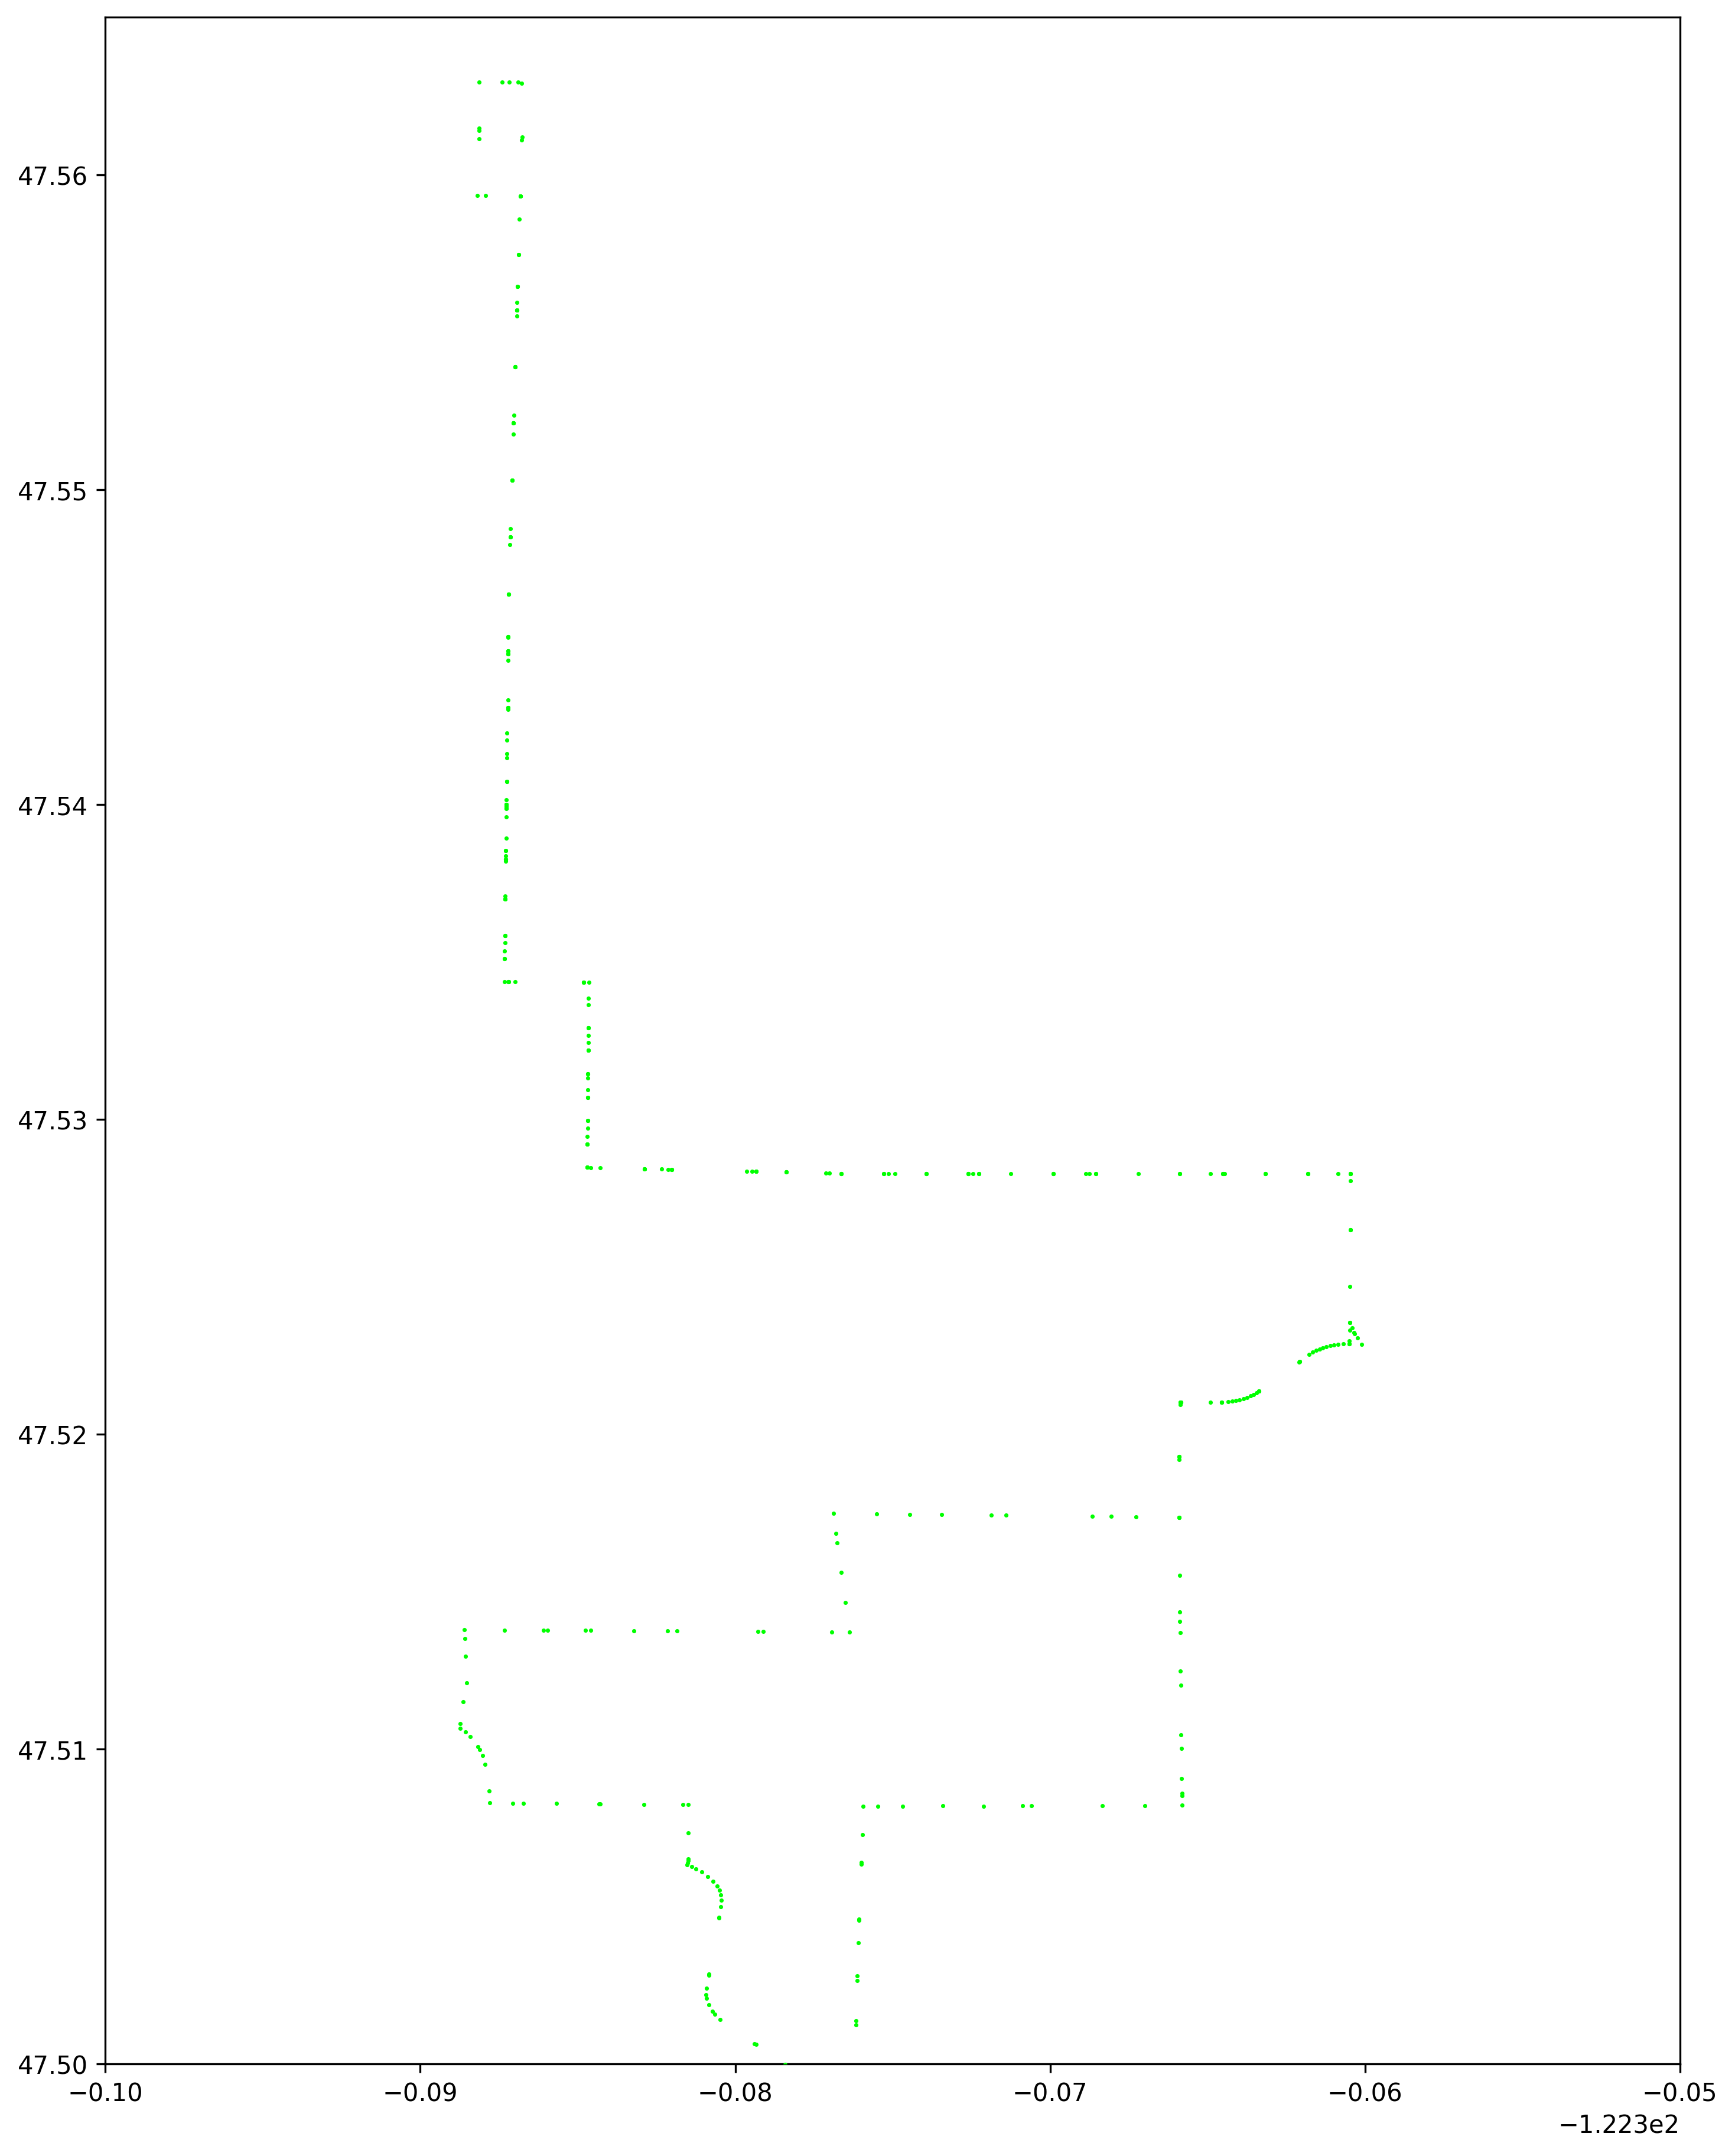

In [118]:
fig, ax = plt.subplots(1, figsize = (15, 15), dpi=300)
ax.set_xlim(-122.4, -122.350)
ax.set_ylim(47.5, 47.565)


seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]


#seattle.plot(color="orange", ax=ax, zorder = 20, alpha = .2)
geometry.plot(color="lime", ax=ax, zorder = 30, markersize=.5)
for index, row in f_gdf.iterrows():
    path = row['path'] + "_reproject.tif"
    filtered_raster_geometry = row['geometry']
    bounds = filtered_raster_geometry .bounds
    extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
    ds = gdal.Open(path)
    rasterArr = np.array(ds.GetRasterBand(1).ReadAsArray())
    with rasterio.open(path) as img:
        print(img.bounds)
        vals = rasterio.sample.sample_gen(img, [(-122.37,47.56), (-122.37,47.55), (-122.37,47.54)], masked=True)
        for elev in vals:
            print(str(type(elev[0])))
        
        show(img, ax=ax, cmap = 'gist_gray', zorder=15)
ax.set_xlim(-122.4, -122.350)
ax.set_ylim(47.5, 47.565)

    #rasterio.warp.reproject(img, src_crs ="NAD83(HARN) / Washington South (ftUS)", dst_crs = "EPSG:4326")
    #show(img, ax=ax)

In [178]:
benchmark_paths = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_Survey_Benchmarks/KC_SURV.shp"
benchmarks = gpd.read_file(benchmark_paths).to_crs(epsg = 4326)
all_benchmarks = {}
benchmark_list = []
benchmarks['ll_tuple'] = benchmarks['geometry'].apply(lambda x: (x.x, x.y))

for index, row in bound_gdf.iterrows():
    path = row['path'] + "_reproject.tif"
    with rasterio.open(path) as img:
        benchmarks['raster_elev'] = list(rasterio.sample.sample_gen(img, list(benchmarks['ll_tuple']), masked=True))
        filtered_benchmarks = benchmarks[benchmarks['raster_elev'].apply(lambda x: str(type(x[0]))) != "<class 'numpy.ma.core.MaskedConstant'>"]
        
        for row_2, col_2 in filtered_benchmarks.iterrows():
            data_dict = {'True_elevation':col_2['ELEVATION'], 'DTM_elevation':col_2['raster_elev'], 'DSM_elevation':None}
            all_benchmarks[row_2] = data_dict

In [179]:
pd.DataFrame(all_benchmarks)

,759,779,150,151,348,397,418,549,623,624,...,527,129,166,761,762,763,764,227,398,294
True_elevation,19.545,19.552,147.77,149.09,36.698,40.87,16.035,81.28,13.359,42.604,...,27.425,4.951,65.908,3.402,2.812,3.923,3.878,3.10,125.76,5.2
DTM_elevation,[218],[204],[169],[112],[221],[115],[221],[168],[229],[123],...,[193],[220],[170],[139],[232],[180],[217],[206],[109],[224]
DSM_elevation,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
vals = src.sample(coords)

In [199]:
fig.savefig("22_alignment_2.png")

In [100]:
str(route_bounds)

'POLYGON ((-122.38874290259594 47.49892287977223, -122.38874290259594 47.56294684155153, -122.36009950624877 47.56294684155153, -122.36009950624877 47.49892287977223, -122.38874290259594 47.49892287977223))'

In [116]:
#filtered_gdf = bound_gdf[bound_gdf['contains_route']==True]


'''
        asciitags = str(meta_dict['GeoAsciiParamsTag'])[2:-4].split("|")
        data_dict = {}
        data_dict['Upper_Left_CD'] = meta_dict['ModelTiepointTag'][3:5]
        for combined_tag in asciitags:

            try:
                split = combined_tag.split(" = ")
                key = split[0]
                value = split[1]
                data_dict[key] = value
            except:
                e = 1
        #print(meta_dict.keys())
        for key in list(meta_dict.keys()):
            if (key != "TileOffsets") and (key != "TileByteCounts"):
                print("{}  |>    {}".format(key, meta_dict[str(key)]))
        metadata_list.append(data_dict)

    #dem = rasterio.open(raster_subset)
    #dem_array = dem.read(1).astype('float64')
    #fig, ax = plt.subplots(1, figsize=(12, 12))
    #show(dem_array, cmap='Greys_r', ax=ax)
'''
#df = pd.DataFrame(metadata_list)
#df


'\n        asciitags = str(meta_dict[\'GeoAsciiParamsTag\'])[2:-4].split("|")\n        data_dict = {}\n        data_dict[\'Upper_Left_CD\'] = meta_dict[\'ModelTiepointTag\'][3:5]\n        for combined_tag in asciitags:\n\n            try:\n                split = combined_tag.split(" = ")\n                key = split[0]\n                value = split[1]\n                data_dict[key] = value\n            except:\n                e = 1\n        #print(meta_dict.keys())\n        for key in list(meta_dict.keys()):\n            if (key != "TileOffsets") and (key != "TileByteCounts"):\n                print("{}  |>    {}".format(key, meta_dict[str(key)]))\n        metadata_list.append(data_dict)\n\n    #dem = rasterio.open(raster_subset)\n    #dem_array = dem.read(1).astype(\'float64\')\n    #fig, ax = plt.subplots(1, figsize=(12, 12))\n    #show(dem_array, cmap=\'Greys_r\', ax=ax)\n'

In [24]:
import rasterio
from rasterio.plot import show

In [9]:
rasterio.open()

Series([], dtype: object)

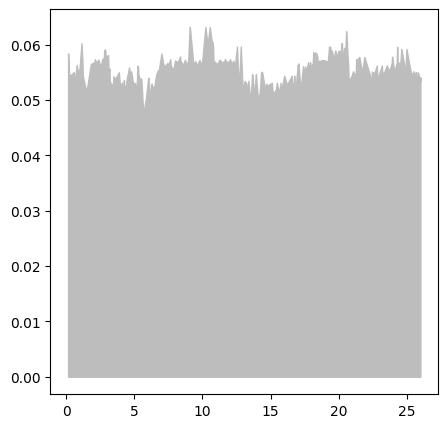

In [16]:
y = pd.Series(elevation, name='Z')*0.0003048
fig, ax = plt.subplots(1, figsize = (5, 5), dpi = 100)
ax.fill_between(x, y, color = '#BDBDBD')

In [ ]:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
geometry.plot(color="lime", ax=ax, markersize=.1, zorder=15)


In [70]:
filtered_elevations

,OBJECTID,GPS_Time,Northing,Easting,Height,YYYYMMDD,geometry
4914,4915,595567,249915.817,1282735.829,1477.828,20160326,POINT Z (-122.28532 47.67589 1477.82800)
4915,4916,595568,249848.274,1282507.102,1484.022,20160326,POINT Z (-122.28624 47.67569 1484.02200)
4916,4917,595569,249781.967,1282279.136,1494.327,20160326,POINT Z (-122.28716 47.67550 1494.32700)
4917,4918,595570,249716.913,1282051.758,1503.057,20160326,POINT Z (-122.28808 47.67531 1503.05700)
4918,4919,595571,249653.591,1281824.830,1511.886,20160326,POINT Z (-122.28900 47.67512 1511.88600)
...,...,...,...,...,...,...,...
347278,347279,421550,242366.190,1281663.530,5126.010,20160225,POINT Z (-122.28909 47.65514 5126.01000)
347279,347280,421551,242121.360,1281661.310,5126.030,20160225,POINT Z (-122.28908 47.65447 5126.03000)
347280,347281,421552,241877.290,1281658.770,5127.660,20160225,POINT Z (-122.28907 47.65380 5127.66000)
347281,347282,421553,241633.820,1281655.690,5128.060,20160225,POINT Z (-122.28907 47.65313 5128.06000)


In [ ]:
route_data_dir = "./Data/Routes/Individual_Routes/"
routefiles_raw = pd.Series(os.listdir(route_data_dir))
routefiles = routefiles_raw[routefiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
routefiles = routefiles.apply(lambda x: "{}{}".format(route_data_dir, x))

In [ ]:
contours_data_dir = "./Data/Contours/"
contourfiles_raw = pd.Series(os.listdir(contours_data_dir))
contourfiles = contourfiles_raw[contourfiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
contourfiles = contourfiles.apply(lambda x: "{}{}".format(contours_data_dir, x))

In [20]:
contour = gpd.read_file(contourfiles[1]).to_crs(epsg = 4326)

In [ ]:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=3000)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

for contour_subset in contourfiles:
    print(contour_subset)
    contour = gpd.read_file(contour_subset).to_crs(epsg = 4326)
    contour.plot(color="tab:orange", ax=ax, markersize=.1)
    del(contour)
    
plt.show()

./Data/Contours/t20r03_contour005.shp
./Data/Contours/t20r11_contour005.shp
./Data/Contours/t22r11_contour005.shp
./Data/Contours/t18r11_contour005.shp
./Data/Contours/t22r09_contour005.shp


In [16]:
elevations = elevations.to_crs(epsg = 4326)

<Axes: >

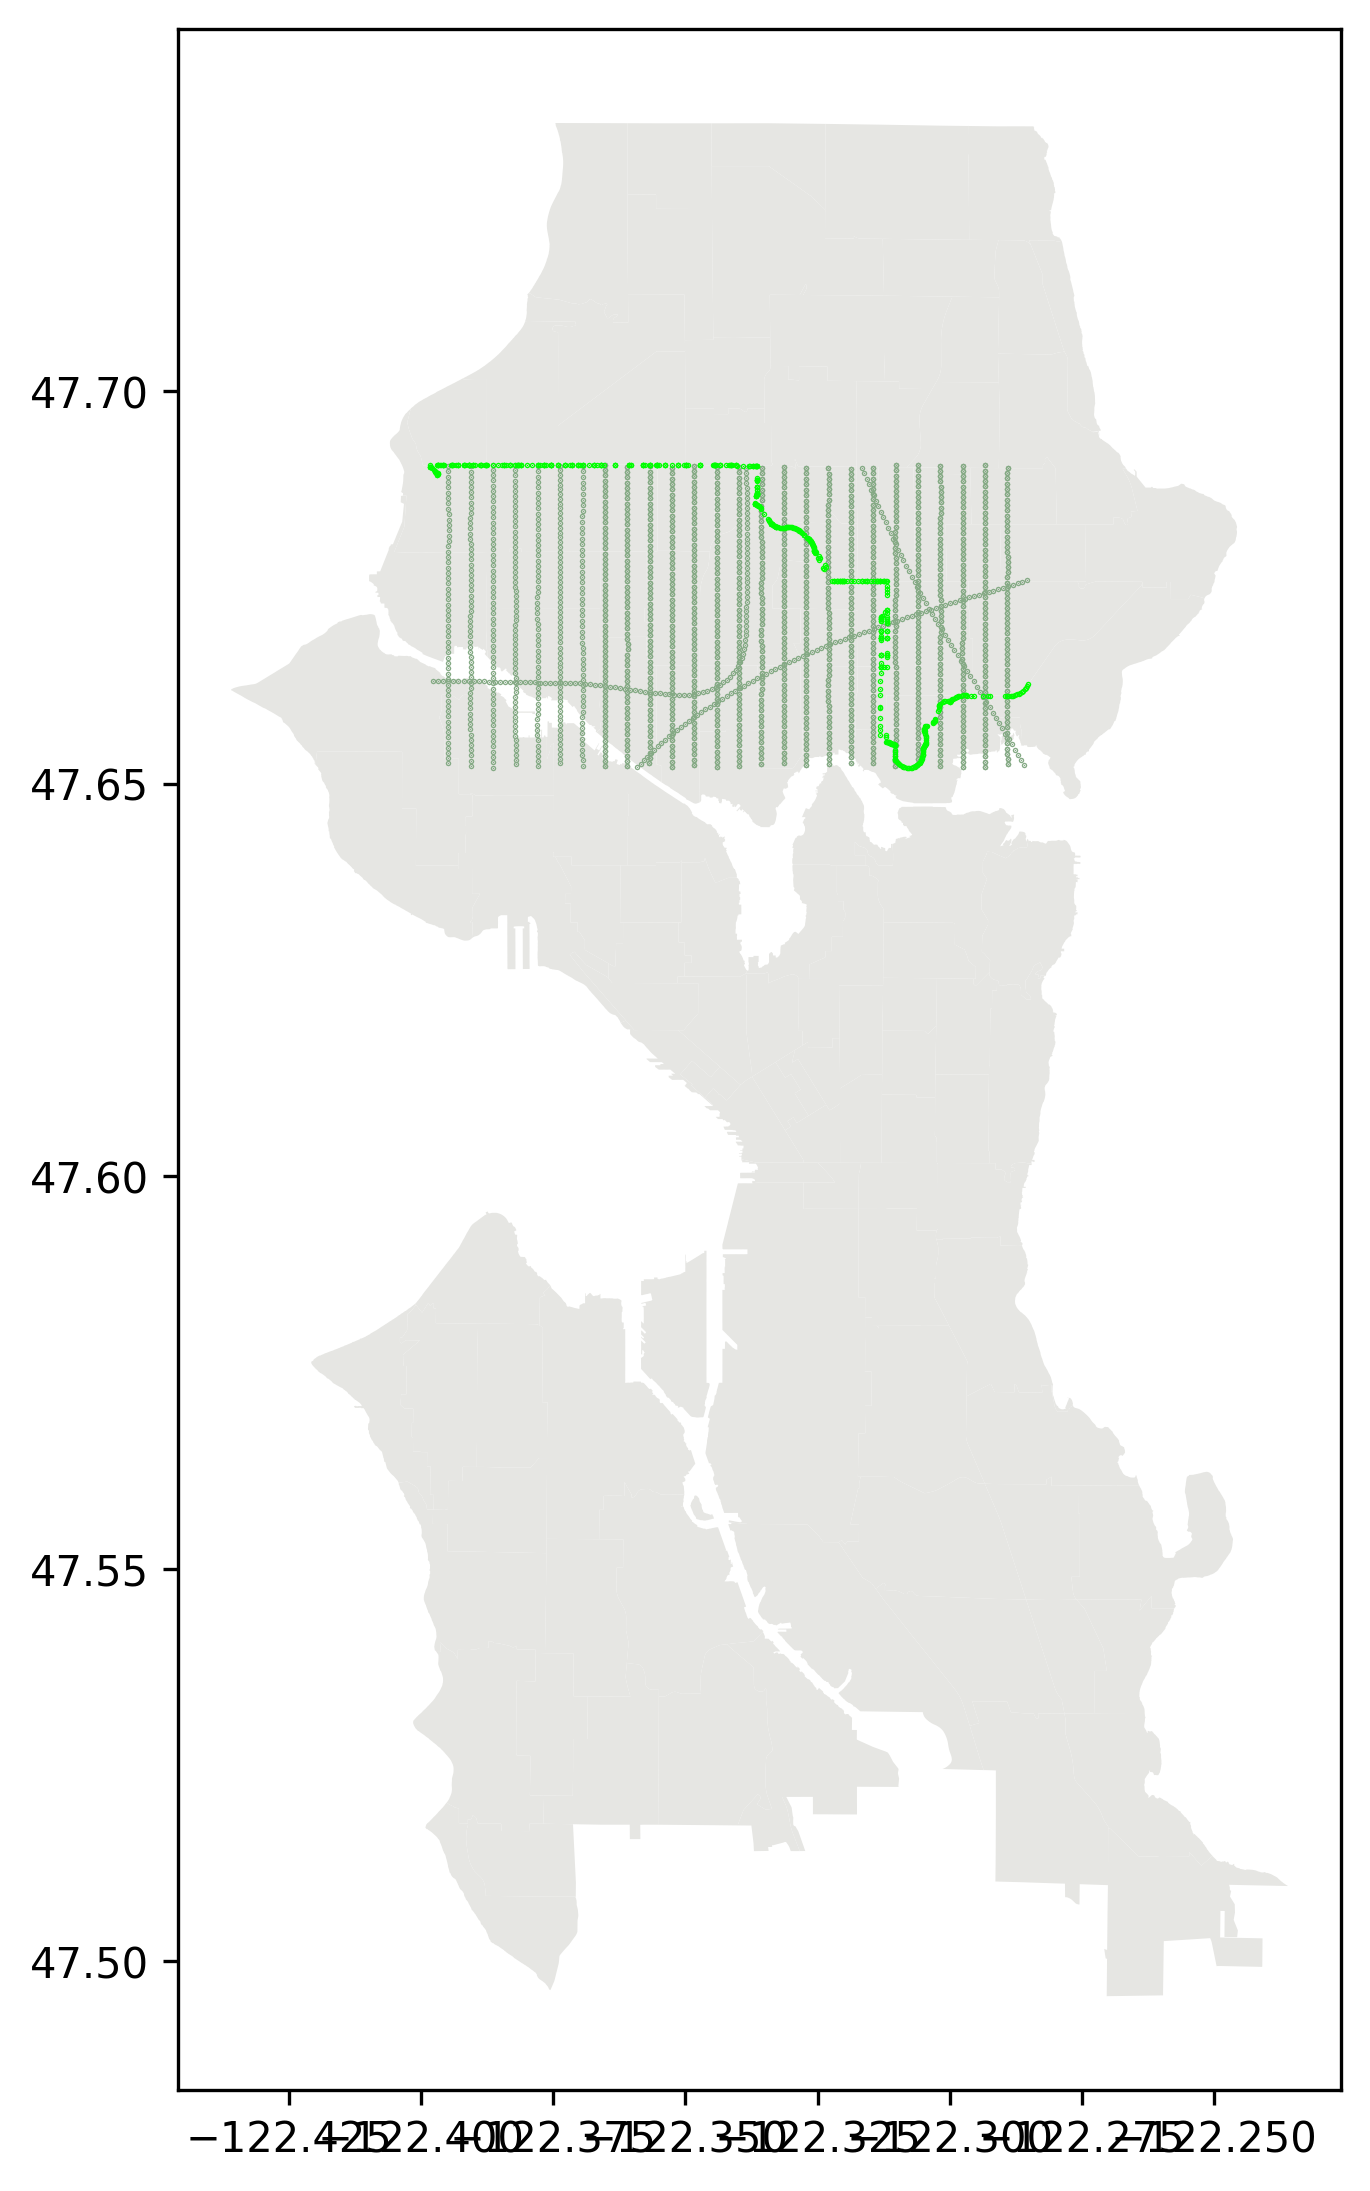

In [18]:
dense_geo = pd.Series(list((routes[routes['ROUTE_NUM'] == route]['geometry'].reset_index(drop=True))[0].geoms))
geometry = gpd.GeoSeries()
for linestring in dense_geo:
    geometry = pd.concat([geometry, organize_linestring(str(linestring))])


route_bounds = hm.get_bounding_box(shapely.LineString(geometry))
filtered_elevations = elevations[(elevations['geometry']).apply(lambda x: shapely.contains(route_bounds, x)) == True]

seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
geometry.plot(color="lime", ax=ax, markersize=.1, zorder=15)
filtered_elevations.plot(color="#85AA85", ax=ax, zorder=.5, markersize=.1)


In [76]:
from PyQt5.QtGui import *
from PyQt5.QtCore import *
from qgis.core import *
from qgis.utils import iface

project = QgsProject.instance() 
mFile=QFileInfo("C://Users//fran//Desktop//test.qgs")

project.write(mFile)

project.clear()

project.read(mFile)

ModuleNotFoundError: No module named 'qgis'

In [74]:
!pip3 install pyqt5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 35.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 21.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 kB 15.8 MB/s eta 0:00:00


In [75]:
!pip3 install qgis

ERROR: Could not find a version that satisfies the requirement qgis (from versions: none)
ERROR: No matching distribution found for qgis
